In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Helper function for Markdown printing
def printmd(string):
    display(Markdown(string))


In [4]:
# Load data
image_dir = Path('gaussian_filtered_images')  # Change this path to your dataset directory
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1).sample(frac=1).reset_index(drop=True)

# Display a sample of the dataset
image_df.head(5)



,Filepath,Label
0,gaussian_filtered_images\Severe\fe0fc67c7980.png,Severe
1,gaussian_filtered_images\Moderate\a9c7b83caf81...,Moderate
2,gaussian_filtered_images\Moderate\b9b6ee2b9453...,Moderate
3,gaussian_filtered_images\No_DR\b7a1bb106051.png,No_DR
4,gaussian_filtered_images\Mild\ad1f7445b1a8.png,Mild


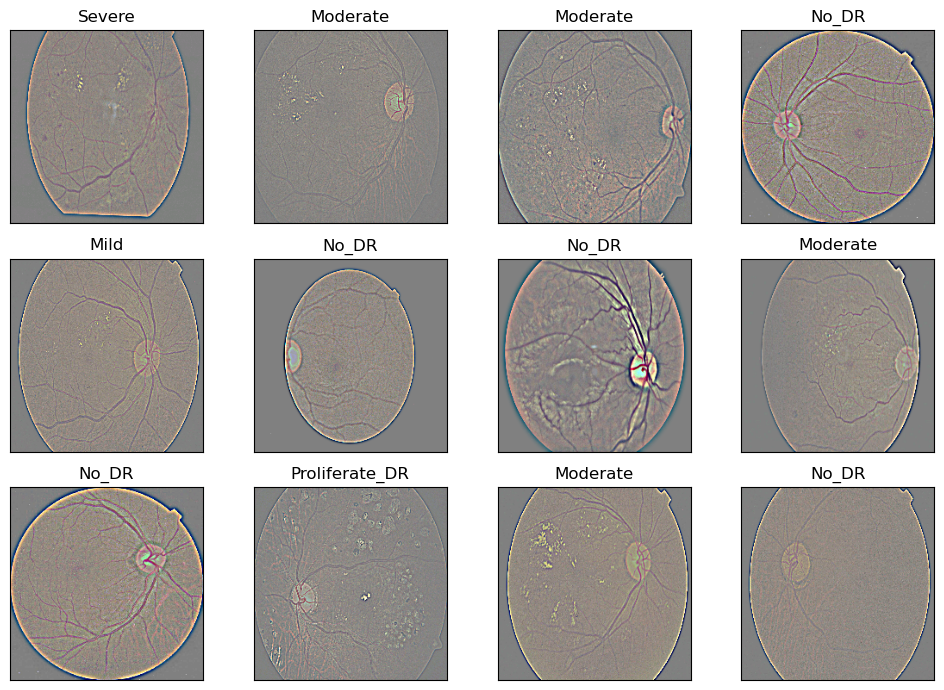

In [5]:

# Visualize sample images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

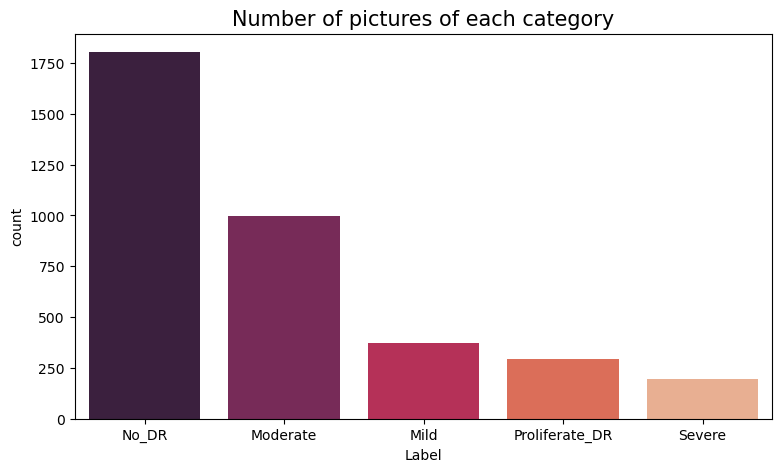

In [34]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# Plot class distribution
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=15)
plt.show()


In [7]:
# Train-test split
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

# Define image generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


In [33]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Define CNN model (MobileNetV2)

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input
cnn_output = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
cnn_output = tf.keras.layers.Dense(64, activation='relu')(cnn_output)
cnn_model = tf.keras.Model(inputs=inputs, outputs=cnn_output)

# Extract CNN features for Random Forest
X_train_cnn = cnn_model.predict(train_images, verbose=1)
y_train_rf = train_images.classes

X_val_cnn = cnn_model.predict(val_images, verbose=1)
y_val_rf = val_images.classes

X_test_cnn = cnn_model.predict(test_images, verbose=1)
y_test_rf = test_images.classes


93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 273ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step


### Random Forest Performance

Validation Accuracy: **0.49**

Test Accuracy: **0.47**

                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        45
      Moderate       0.33      0.12      0.18        96
         No_DR       0.49      0.90      0.63       176
Proliferate_DR       0.25      0.04      0.06        28
        Severe       0.00      0.00      0.00        22

      accuracy                           0.47       367
     macro avg       0.21      0.21      0.18       367
  weighted avg       0.34      0.47      0.36       367



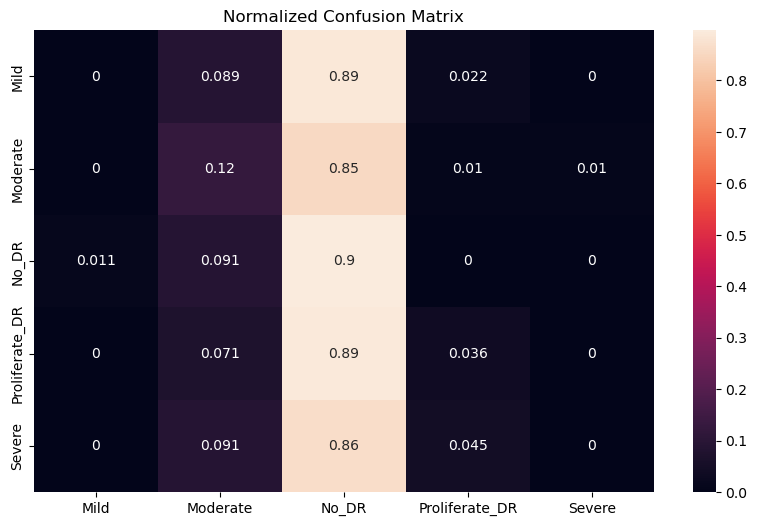

In [9]:
# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_cnn, y_train_rf)

# Evaluate validation and test accuracy
val_acc_rf = rf.score(X_val_cnn, y_val_rf)
test_acc_rf = rf.score(X_test_cnn, y_test_rf)

printmd(f"### Random Forest Performance")
printmd(f"Validation Accuracy: **{val_acc_rf:.2f}**")
printmd(f"Test Accuracy: **{test_acc_rf:.2f}**")

# Classification report and confusion matrix
y_pred_rf = rf.predict(X_test_cnn)
print(classification_report(y_test_rf, y_pred_rf, target_names=list(test_images.class_indices.keys())))

cf_matrix = confusion_matrix(y_test_rf, y_pred_rf, normalize='true')
plt.figure(figsize=(10, 6))
sns.heatmap(cf_matrix, annot=True, xticklabels=list(test_images.class_indices.keys()), yticklabels=list(test_images.class_indices.keys()))
plt.title('Normalized Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/

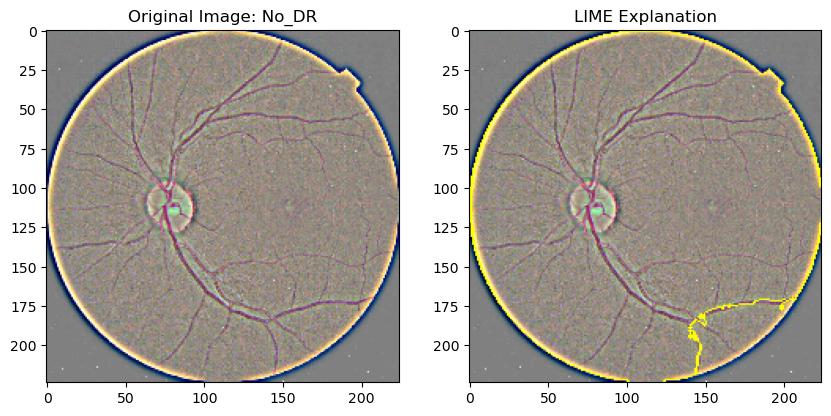

In [32]:
import numpy as np
import tensorflow as tf
import lime
import lime.lime_image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Load and use a pre-trained CNN model (MobileNetV2)
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  # Global average pooling layer to reduce dimensions
)
pretrained_model.trainable = False

# Example of loading a sample image from your dataset
sample_idx = 0  # Select the index of the image you want to explain
image = plt.imread(test_df.Filepath.iloc[sample_idx])  # Assuming you have a 'Filepath' column with image paths

# Resize the image to the expected input shape (224x224x3 for MobileNetV2)
image_resized = tf.image.resize(image, (224, 224))
image_resized = np.expand_dims(image_resized, axis=0)  # Add batch dimension (1, 224, 224, 3)

# CNN model prediction
cnn_model_output = pretrained_model.predict(image_resized)

# LIME Explanation
def cnn_predict_wrapper(image):
    # Predict using CNN and return the class probabilities
    return pretrained_model.predict(image)

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the instance
explanation = explainer.explain_instance(
    image_resized[0],  # Pass the single image
    cnn_predict_wrapper,  # The model's prediction function
    top_labels=1,  # Focus on the top predicted label
    hide_color=0,
    num_samples=1000  # Number of perturbed samples for explanation
)

# Get the explanation and visualization
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Display the original image and LIME explanation side by side
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_resized[0])
plt.title(f"Original Image: {test_df.Label.iloc[sample_idx]}")

# LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation")

plt.show()
